# Quantum dataset - logistic

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel

from src.machinery.GradientDescent import ArtemisDescent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "quantum"

nb_devices_for_the_run = 10
MAX_NB_DEVICES = 10

# Data preparation

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/quantum/phy_train.csv', sep="\t", header = None)
columns_with_missing_values = []
for col in range(1, len(data.columns)):
    if (not data[data[col] == 999].empty) or (not data[data[col] == 9999].empty):
        columns_with_missing_values.append(col)
print("Following columns has missing values :", columns_with_missing_values)
data.drop(data.columns[columns_with_missing_values],axis=1,inplace=True)
print("This columns has been removed.")
data = data.rename(columns={ 0: "ID", 1: "state", 80: "nothing" })
data = data.drop(['ID', 'nothing'], axis=1)
data.head()

Following columns has missing values : [21, 22, 23, 30, 45, 46, 47, 56]
This columns has been removed.


,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,0,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [3]:
dim_notebook = len(data.columns) - 1 # We don't count as dimension the labels
print("There is " + str(dim_notebook) + " dimensions.")

There is 70 dimensions.


In [4]:
# Showing that there is empty columns (with null std).
small_std = []
std_data = data.std()
for i in range(len(data.columns)):
    if std_data.iloc[i] < 1e-5:
        small_std.append(i)
print(small_std)
data.iloc[:,small_std].describe()

[40, 41, 42, 43, 44]


,48,49,50,51,52
count,50000.0,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [5]:
# Removing columns with null std
data = data.loc[:, (data.std() > 1e-6)]
dim_notebook = len(data.columns) - 1
print("Now, there is " + str(dim_notebook) + " dimensions.")

Now, there is 65 dimensions.


In [6]:
data = data.replace({'state': {0: -1}})
data.head()

,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,-1,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,-1,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [7]:
data['state'].value_counts()

-1    25139
 1    24861
Name: state, dtype: int64

In [8]:
#Separing features and labels
X_data = data.loc[:, data.columns != "state"]
Y_data = data.loc[:, data.columns == "state"]

#Data normalisation
X_scaled = scale(X_data)
Y_scaled = Y_data

## Handling IID data

In [9]:
#Transforming into torch.FloatTensor
X_merged = torch.tensor(X_scaled, dtype=torch.float64)
Y_merged = torch.tensor(Y_scaled.values, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")

# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
dim_notebook = X[0].shape[1]
for x in X:
    print("Number of points on this device:", len(x))

Number of points by devices:  5000
There is 10 devices.
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000


In [10]:
# Checking that data is balanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.495
ratio of state 1 on this device:  0.4904
ratio of state 1 on this device:  0.5066
ratio of state 1 on this device:  0.4892
ratio of state 1 on this device:  0.5108
ratio of state 1 on this device:  0.4884
ratio of state 1 on this device:  0.5016
ratio of state 1 on this device:  0.4962
ratio of state 1 on this device:  0.4932
ratio of state 1 on this device:  0.5008


In [11]:
%%time
obj_min_by_N = {}
for nb_devices in tqdm([10]):
    obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=LogisticModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
    obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
    obj_min_by_N_descent.run()
    obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-iid-obj_min")

  0%|          | 0/1 [00:00<?, ?it/s]

   it    |   obj   
    4000 | 5.4297e-01
    8000 | 5.4297e-01
   12000 | 5.4297e-01
   16000 | 5.4297e-01


100%|██████████| 1/1 [03:05<00:00, 185.79s/it]

Gradient Descent: execution time=185.608 seconds
Final loss :  0.5429732060080666



CPU times: user 38min 57s, sys: 2min 43s, total: 41min 41s
Wall time: 3min 6s


In [12]:
id = 5
x = X[id]
w = obj_min_by_N_descent.model_params[-1]
mul = x.mv(w)
inf_middle = 0
failure = 0
for i in range(len(mul)):
    if torch.sigmoid(mul[i]) > 0.5:
        if Y[id][i] != 1:
            failure +=1
        inf_middle +=1
print("Number of labels equal to 1: ", inf_middle)
print("Failures:", failure)
print("Percent of labels wrongly predicted to be state 1: " + str(failure/inf_middle) + "%")

Number of labels equal to 1:  2419
Failures: 706
Percent of labels wrongly predicted to be state 1: 0.29185613890037204%


In [13]:
%%time
all_descent = {}
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, myX, myY, model = LogisticModel(), 
                                               use_averaging=True)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-iid-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD


 20%|██        | 1/5 [1:23:05<5:32:20, 4985.07s/it]

QSGD


 40%|████      | 2/5 [3:51:07<5:07:43, 6154.38s/it]

Diana


 60%|██████    | 3/5 [6:23:56<3:55:17, 7058.58s/it]

BiQSGD


 80%|████████  | 4/5 [8:58:28<2:08:42, 7722.56s/it]

Artemis


100%|██████████| 5/5 [11:35:37<00:00, 8347.60s/it]

CPU times: user 12h 51min 20s, sys: 20min 31s, total: 13h 11min 51s
Wall time: 11h 35min 38s


In [14]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([-2.0945e-02,  5.0254e-02, -1.4778e-02,  6.4691e-02,  7.2540e-01,
        -7.3856e-03,  9.8926e-03, -1.6933e-02,  2.9025e-01,  9.6255e-05,
         1.9315e-02, -1.2879e-02, -2.9273e-02,  1.0021e+00,  4.3859e-01,
         1.7658e-01, -2.1869e-02, -4.8349e-02,  2.6064e-02, -9.7400e-03,
         2.4409e-02,  2.0820e-02, -2.3715e-02,  7.3605e-02,  9.2386e-03,
         2.0625e-02, -3.5843e-03, -1.4195e-01, -1.2010e-03, -1.7353e-02,
         3.0643e-02,  1.4236e-02,  1.3829e-03, -6.0013e-02,  4.9333e-03,
        -4.0240e-02, -6.0265e-02,  4.2835e-03,  4.6386e-02, -8.3999e-03,
         1.0137e-03, -3.8569e-02, -1.3060e-02, -3.6674e-02, -3.9987e-02,
         1.1622e-03,  3.8806e-02, -3.7789e-02, -1.2780e-02,  4.7813e-02,
         1.1591e-01,  3.4680e-03, -1.9360e-02,  1.7584e-01,  3.0162e-02,
        -4.1792e-02, -1.0884e-01, -6.0575e-02,  3.3198e-01,  1.6605e-03,
         1.0409e-02, -1.1302e-02, -6.0375e-

### With averaging

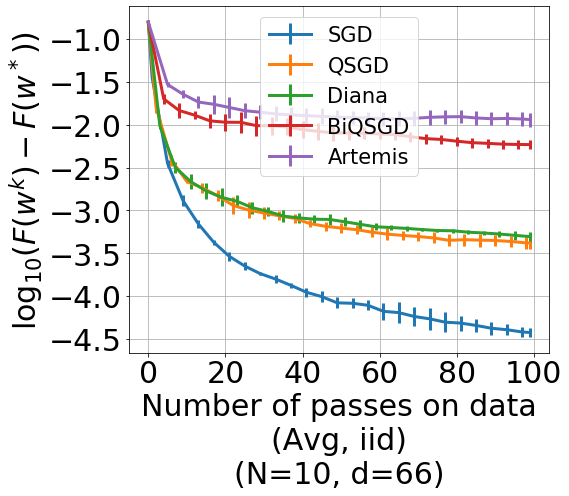

In [11]:
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), x_legend="Number of passes on data\n(Avg, iid)") 

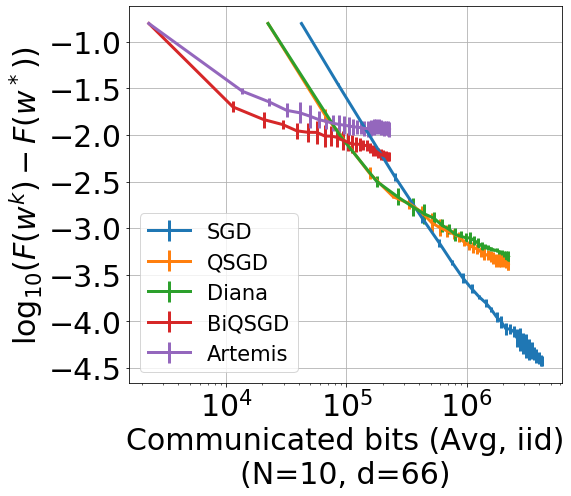

In [12]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits (Avg, iid)") 


### Without averaging

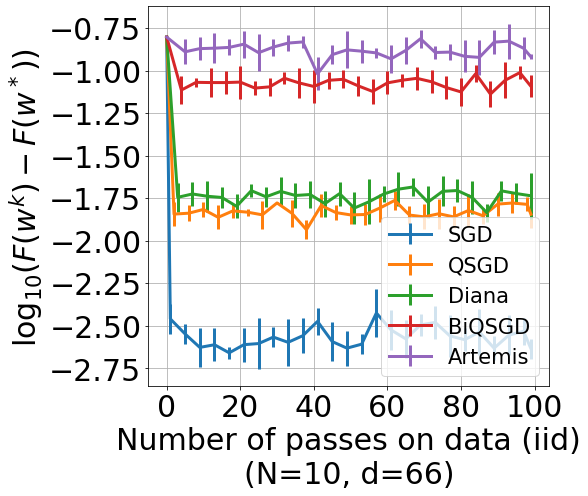

In [13]:
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_legend="Number of passes on data (iid)", all_error=res.get_std(obj)) 

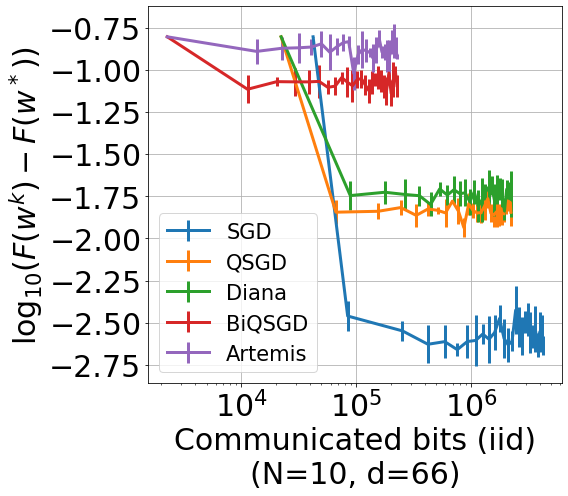

In [18]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits (iid)", all_error=res.get_std(obj)) 

# Handling non-iid data

CPU times: user 40min 19s, sys: 2min 21s, total: 42min 40s
Wall time: 7min 59s


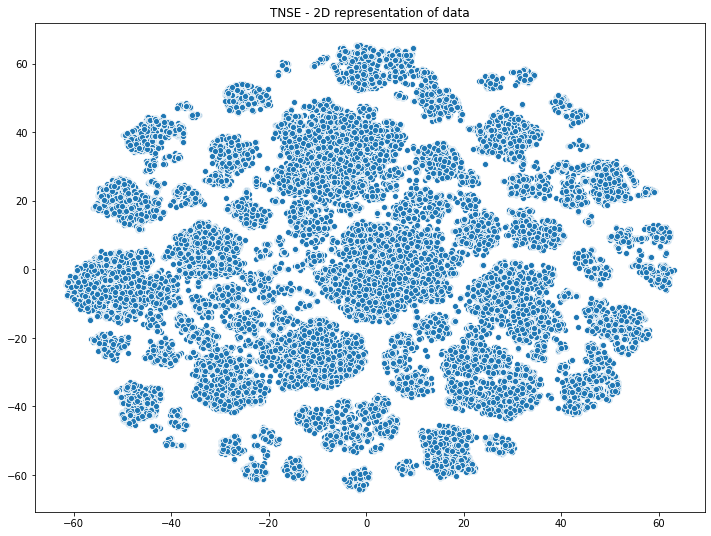

In [19]:
%%time
# Running TNSE to obtain a 2D representation of data
embedded_data = tnse(data)
pickle_saver(embedded_data, filename + "-tsne")

There is 10 devices.
Number of points on device 0 : 5782
Number of points on device 1 : 3923
Number of points on device 2 : 16331
Number of points on device 3 : 1783
Number of points on device 4 : 2486
Number of points on device 5 : 3693
Number of points on device 6 : 3836
Number of points on device 7 : 4069
Number of points on device 8 : 2428
Number of points on device 9 : 5669
CPU times: user 5min 32s, sys: 25.3 s, total: 5min 57s
Wall time: 24.8 s


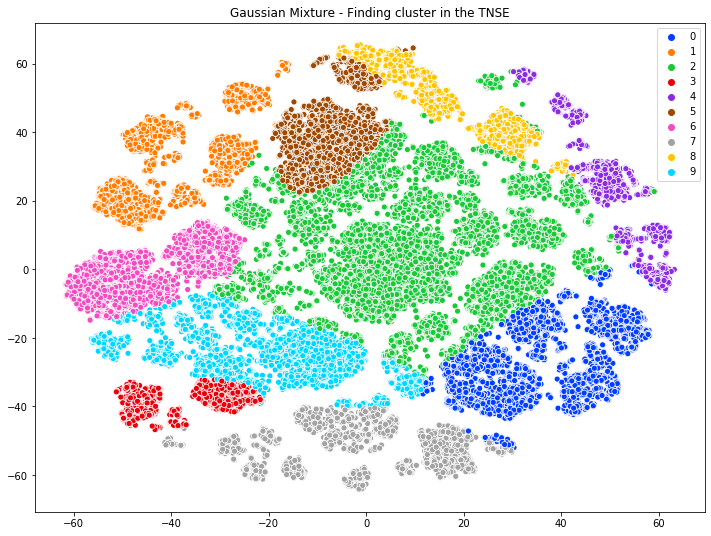

In [20]:



%%time
nb_cluster = 10
embedded_data = pickle_loader(filename + "-tsne")
# Finding cluster in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "state", nb_cluster, scale_Y=False)
dim_notebook = X[0].shape[1]

CPU times: user 36min 41s, sys: 2min 20s, total: 39min 1s
Wall time: 6min 37s


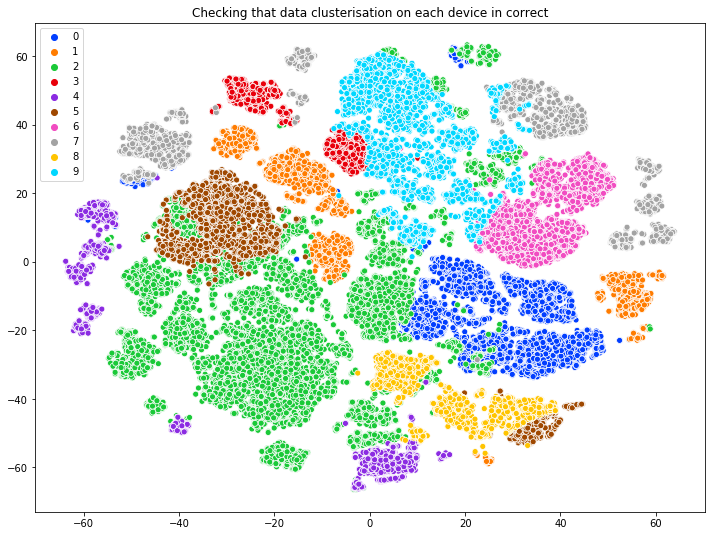

In [21]:
%%time
#Checking that splitting data by cluster is valid.
check_data_clusterisation(X,Y, nb_cluster)

In [22]:
# Checking that data is unbalanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.43998616395710827
ratio of state 1 on this device:  0.6140708641345909
ratio of state 1 on this device:  0.4487171636764436
ratio of state 1 on this device:  0.4655075715086932
ratio of state 1 on this device:  0.4658085277554304
ratio of state 1 on this device:  0.7319252640129975
ratio of state 1 on this device:  0.3970281543274244
ratio of state 1 on this device:  0.40108134676824775
ratio of state 1 on this device:  0.5354200988467874
ratio of state 1 on this device:  0.6057505732933498


In [23]:
%%time
obj_min_by_N = {}
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                     nb_devices=nb_cluster,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=LogisticModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
obj_min_by_N_descent.set_data(X,Y)
obj_min_by_N_descent.run()
obj_min_by_N[nb_cluster] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-noniid-obj_min")

   it    |   obj   
    4000 | 5.3642e-01
    8000 | 5.3642e-01
   12000 | 5.3642e-01
   16000 | 5.3642e-01
Gradient Descent: execution time=140.368 seconds
Final loss :  0.5364168917334904

CPU times: user 32min 18s, sys: 1min 54s, total: 34min 12s
Wall time: 2min 20s


## Batch size $= 1$ (stochastic)

In [24]:
%%time
all_descent = {}
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, X, Y, model = LogisticModel(), 
                                               use_averaging=True, stochastic=True)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD


 20%|██        | 1/5 [30:29<2:01:58, 1829.67s/it]

QSGD


 40%|████      | 2/5 [1:22:09<1:50:31, 2210.58s/it]

Diana


 60%|██████    | 3/5 [2:14:30<1:22:59, 2489.83s/it]

BiQSGD


 80%|████████  | 4/5 [3:08:06<45:07, 2707.57s/it]  

Artemis


100%|██████████| 5/5 [4:02:15<00:00, 2907.13s/it]

CPU times: user 5h 38min 16s, sys: 8min 45s, total: 5h 47min 1s
Wall time: 4h 2min 15s


### With averaging

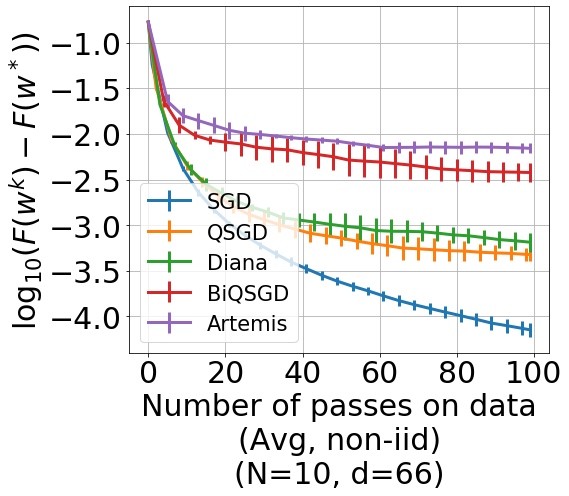

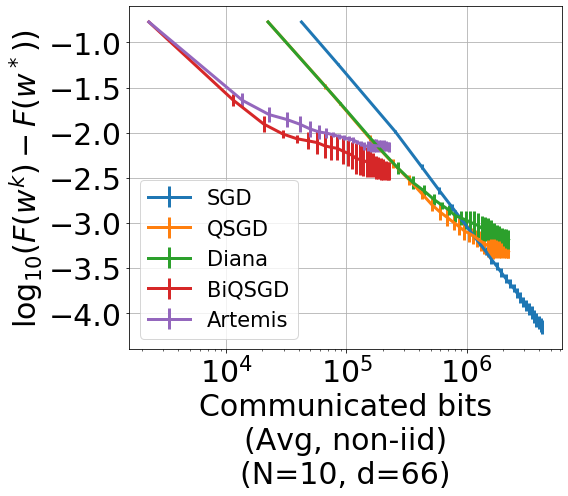

In [25]:
obj_min_by_N = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")
obj = obj_min_by_N[len(X)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits, 
                x_legend="Communicated bits\n(Avg, non-iid)", all_error=res.get_std(obj, averaged=True)) 

### Without averaging

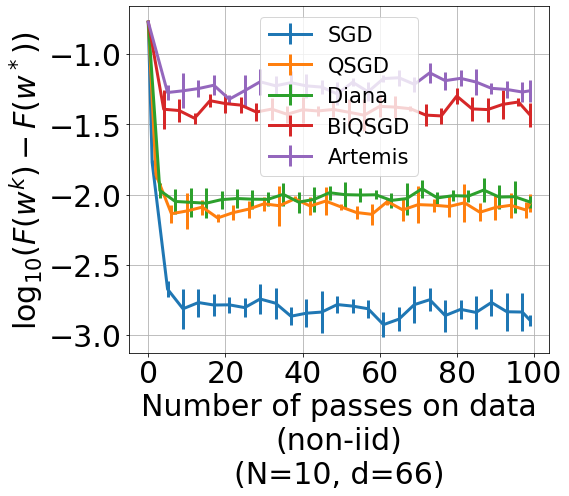

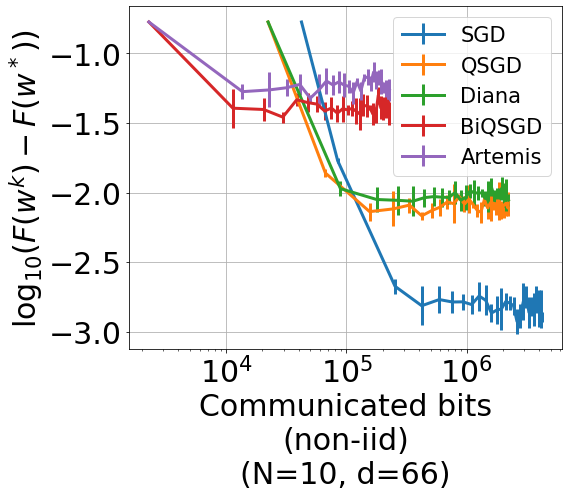

In [26]:
obj_min_by_N = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")
obj = obj_min_by_N[len(X)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits, 
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

## Batch size $= 800$

In [27]:
%%time
batch_size = 800
all_descent = {}
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, X, Y, model = LogisticModel(), 
                                               use_averaging=True, stochastic=True, batch_size=batch_size, 
                                               nb_epoch=1000)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent-800")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD


 20%|██        | 1/5 [12:15<49:01, 735.42s/it]

QSGD


 40%|████      | 2/5 [24:49<37:03, 741.11s/it]

Diana


 60%|██████    | 3/5 [38:04<25:14, 757.24s/it]

BiQSGD


 80%|████████  | 4/5 [51:23<12:49, 769.58s/it]

Artemis


100%|██████████| 5/5 [1:04:16<00:00, 771.24s/it]

CPU times: user 14h 28min 16s, sys: 1h 4min 56s, total: 15h 33min 13s
Wall time: 1h 4min 16s


### With averaging

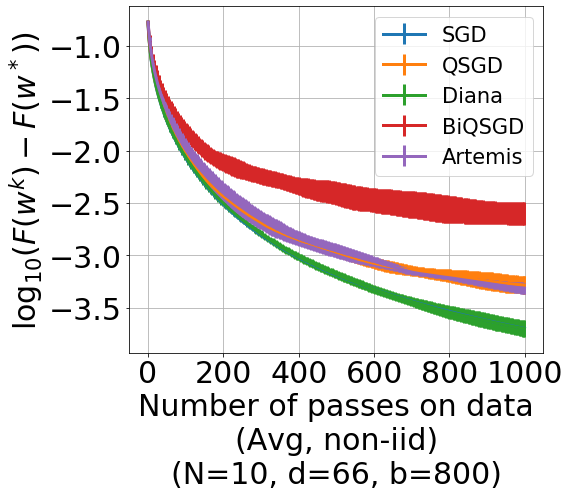

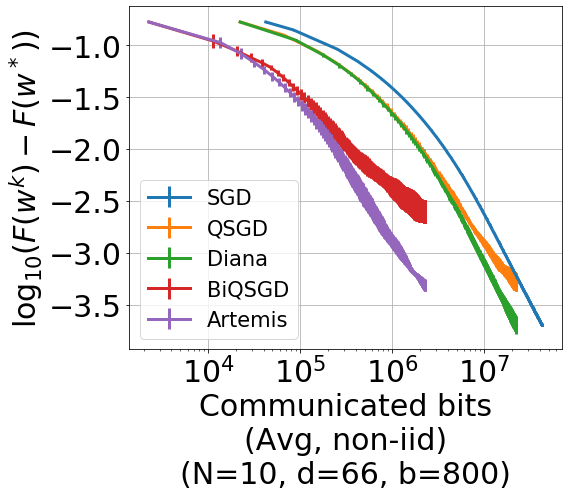

In [28]:
obj_min_by_N = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent-800")
obj = obj_min_by_N[len(X)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Number of passes on data\n(Avg, non-iid)") 

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(Avg, non-iid)", all_error=res.get_std(obj, averaged=True)) 

### Without averaging

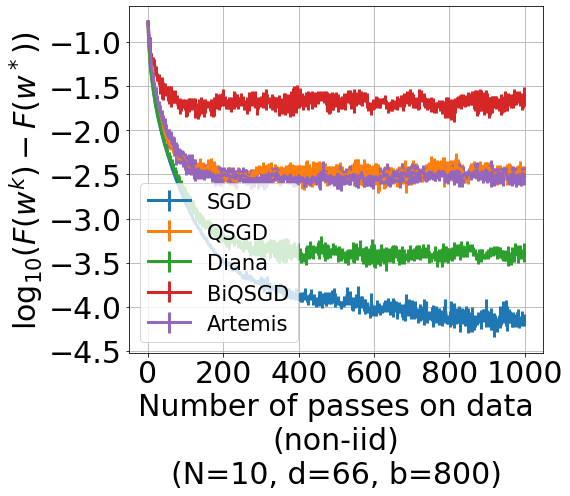

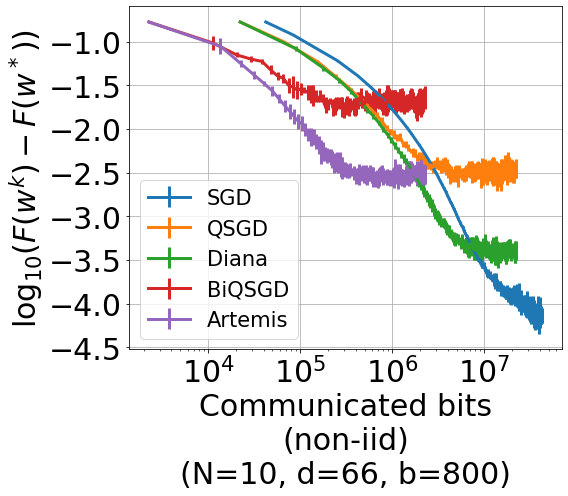

In [29]:
obj_min_by_N = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent-800")
obj = obj_min_by_N[len(X)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 